In [2]:
import numpy as np
import cv2 as cv
import cv2
from cv2 import aruco, cvtColor, COLOR_BGR2GRAY, LUT
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd

In [3]:
imgs = glob("../../serie1/*.jpg")
imgs

['../../serie1/camera01.jpg',
 '../../serie1/camera02.jpg',
 '../../serie1/camera03.jpg',
 '../../serie1/camera04.jpg',
 '../../serie1/camera05.jpg',
 '../../serie1/camera06.jpg',
 '../../serie1/camera07.jpg',
 '../../serie1/camera08.jpg',
 '../../serie1/camera09.jpg',
 '../../serie1/camera10.jpg',
 '../../serie1/camera11.jpg',
 '../../serie1/camera12.jpg',
 '../../serie1/camera13.jpg',
 '../../serie1/camera14.jpg',
 '../../serie1/camera15.jpg',
 '../../serie1/camera16.jpg',
 '../../serie1/camera17.jpg',
 '../../serie1/camera18.jpg',
 '../../serie1/camera19.jpg',
 '../../serie1/camera20.jpg',
 '../../serie1/camera21.jpg',
 '../../serie1/camera22.jpg',
 '../../serie1/camera23.jpg',
 '../../serie1/camera24.jpg']

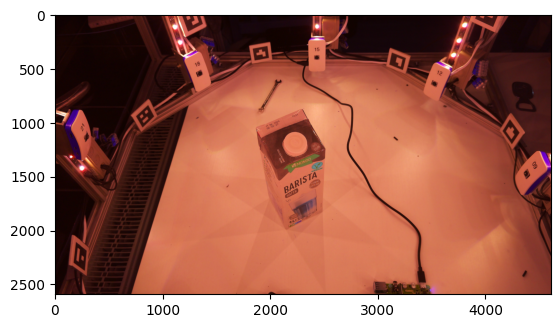

In [4]:

imgsCV = [cv.imread(i) for i in imgs]
plt.figure()
plt.imshow(imgsCV[0])
plt.show()

In [5]:
aruco_dict = aruco.extendDictionary(32, 3)

In [6]:
parameter = aruco.DetectorParameters()
parameter.cornerRefinementMethod = aruco.CORNER_REFINE_SUBPIX
LUT_IN = [0, 158, 216, 255]
LUT_OUT = [0, 22, 80, 176]
lut = np.interp(np.arange(0, 256),
                LUT_IN, LUT_OUT).astype(np.uint8)

In [15]:
corners = []
for j in range(len(imgsCV)):
    gray = cvtColor(imgsCV[j], COLOR_BGR2GRAY)
    tmp_corners, tmp_ids, t = aruco.detectMarkers(gray, aruco_dict, parameters=parameter)
    for c, i in zip(tmp_corners, tmp_ids):
        for k in range(len(c[0])):
            corners.append([j, i[0], k, c[0][k][0], c[0][k][1]])


In [16]:
corners = pd.DataFrame(corners, columns=["img", "marker", "ecke", "x", "y"])
corners.set_index(["img", "marker", "ecke"], inplace=True)
corners

x            y
img marker ecke                          
0   0      0     1969.539429   297.320587
           1     1981.801514   407.178833
           2     1852.734985   430.239105
           3     1833.315918   321.256836
    13     0      194.009140  2110.138184
...                      ...          ...
23  9      3     1180.403442   830.981873
    16     0     4285.006836   910.371643
           1     4060.363281   929.256897
           2     4059.873535   723.031067
           3     4284.933105   693.774963

[552 rows x 2 columns]

In [17]:
ca = corners.reset_index().set_index(["marker", "ecke"])
matched = ca.join(ca, lsuffix="_a", rsuffix="_b").query('img_a < img_b')
matched.reset_index(inplace=True)
#matched.set_index(["img", "marker", "ecke"], inplace=True)
#matched.sort_index(inplace=True)
matched

,marker,ecke,img_a,x_a,y_a,img_b,x_b,y_b
0,0,0,0,1969.539429,297.320587,1,1831.776855,1186.525391
1,0,0,0,1969.539429,297.320587,3,2945.488525,606.490540
2,0,0,0,1969.539429,297.320587,4,3121.062012,1094.036377
3,0,0,0,1969.539429,297.320587,5,3313.230957,1945.385620
4,0,0,0,1969.539429,297.320587,6,4121.467285,1462.811157
...,...,...,...,...,...,...,...,...
2027,16,3,22,3892.248779,1021.020813,23,4284.933105,693.774963
2028,17,0,6,2175.000000,1530.000000,7,2021.639648,1457.814087
2029,17,1,6,2174.000000,1567.000000,7,2020.157471,1542.136108
2030,17,2,6,2160.000000,1547.000000,7,2001.038696,1525.470093


In [90]:
best = matched.groupby(['img_a', 'img_b'])['marker'].count()      .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)
best

,img_a,img_b,count
47,3,6,32
81,6,7,28
20,1,3,28
48,3,7,24
180,18,19,24
...,...,...,...
155,14,16,4
157,14,19,4
35,2,4,4
98,7,21,4


In [19]:
mtx = np.array([[3.48172482e+03, 0.00000000e+00, 2.30250916e+03],
                [0.00000000e+00, 3.47313834e+03, 1.31660435e+03],
                [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
dist = np.array([[-1.41372220e-02,  2.43909839e-01,
                1.15659062e-03,  1.28627153e-04,  -5.96950573e-01]])
#dist = np.array([[0, 0, 0, 0, 0]])

In [105]:
import cv2
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from random import choices
from typing import List, Any
from numpy.typing import NDArray

def cart2hom(arr: NDArray[np.float32]) -> NDArray[np.float32]:
    """ Convert catesian to homogenous points by appending a row of 1s
    :param arr: array of shape (num_dimension x num_points)
    :returns: array of shape ((num_dimension+1) x num_points)
    """
    if arr.ndim == 1:
        return np.hstack([arr, 1])
    return np.asarray(np.vstack([arr, np.ones(arr.shape[1])]))


def scale_and_translate_points(points: NDArray[np.float32]) -> tuple[Any, NDArray[Any]]:
    """ Scale and translate image points so that centroid of the points
        are at the origin and avg distance to the origin is equal to sqrt(2).
        Hartley p109
    :param points: array of homogenous point (3 x n)
    :returns: array of same input shape and its normalization matrix
    """
    x = points[0]
    y = points[1]
    center = points.mean(axis=1)  # mean of each row
    cx = x - center[0]  # center the points
    cy = y - center[1]
    dist = np.sqrt(np.power(cx, 2) + np.power(cy, 2))
    scale = np.sqrt(2) / dist.mean()
    norm3d = np.array([
        [scale, 0, -scale * center[0]],
        [0, scale, -scale * center[1]],
        [0, 0, 1]
    ])

    return np.dot(norm3d, points), norm3d


def correspondence_matrix(p1: NDArray[np.float32], p2: NDArray[np.float32]) -> NDArray[np.float64]:
    """Each row in the A matrix below is constructed as
        [x'*x, x'*y, x', y'*x, y'*y, y', x, y, 1]
        Hartley p279"""
    p1x, p1y = p1[:2]
    p2x, p2y = p2[:2]

    return np.array([
        p1x * p2x, p1x * p2y, p1x,
        p1y * p2x, p1y * p2y, p1y,
        p2x, p2y, np.ones(len(p1x))
    ]).T


def compute_essential_normalized(p1: NDArray[np.float32], p2: NDArray[np.float32]) -> NDArray[np.float64]:
    """ Computes the fundamental or essential matrix from corresponding points
        using the normalized 8 point algorithm.
        Hartley p294
    :input p1, p2: corresponding points with shape 3 x n
    :returns: fundamental or essential matrix with shape 3 x 3
    """
    n = p1.shape[1]
    if p2.shape[1] != n:
        raise ValueError('Number of points do not match.')

    # preprocess image coordinates
    # Hartley p282
    p1n, T1 = scale_and_translate_points(p1)
    p2n, T2 = scale_and_translate_points(p2)

    # compute F or E with the coordinates
    # Harley p280
    A = correspondence_matrix(p1n, p2n)
    # compute linear least square solution
    U, S, V = np.linalg.svd(A)
    F: NDArray[np.float64] = V[-1].reshape(3, 3)

    # constrain F. Make rank 2 by zeroing out last singular value
    # Hartley p. 259
    U, S, V = np.linalg.svd(F)
    # S[-1] = 0 # Fundamental Hartley p.281
    S = np.array([1, 1, 0])  # Force rank 2 and equal eigenvalues
    F = U @ np.diag(S) @ V

    # reverse preprocessing of coordinates
    # We know that P1' E P2 = 0
    # Hartley p282
    F = T1.T@F@T2

    np.divide(F, F[2, 2], F)
    return F


def reconstruct_points(p1: NDArray[np.float32], p2: NDArray[np.float32], m1: NDArray[np.float32], m2: NDArray[np.float32]) -> NDArray[np.float64]:
    num_points = p1.shape[1]
    res = np.ones((4, num_points))

    for i in range(num_points):
        res[:, i] = reconstruct_one_point(p1[:, i], p2[:, i], m1, m2)

    return res


def skew(x: NDArray[np.float32]) -> NDArray[np.float64]:
    """ Create a skew symmetric matrix *A* from a 3d vector *x*.
        Property: np.cross(A, v) == np.dot(x, v)
    :param x: 3d vector
    :returns: 3 x 3 skew symmetric matrix from *x*
    """
    return np.array([
        [0, -x[2], x[1]],
        [x[2], 0, -x[0]],
        [-x[1], x[0], 0]
    ], dtype=np.float64)


def reconstruct_one_point(pt1: NDArray[np.float32], pt2: NDArray[np.float32], m1: NDArray[np.float32], m2: NDArray[np.float32]) -> NDArray[np.float64]:
    """
        pt1 and m1 * X are parallel and cross product = 0
        pt1 x m1 * X  =  pt2 x m2 * X  =  0
        :param p1, p2: 2D points in homo. or catesian coordinates. Shape (3 x n)
        :param m1, m2: Camera matrices associated with p1 and p2. Shape (3 x 4)
    """
    A = np.vstack([
        np.dot(skew(pt1), m1),
        np.dot(skew(pt2), m2)
    ])
    U, S, V = np.linalg.svd(A)
    P = np.ravel(V[-1, :4])

    np.divide(P, P[3])
    return P


def linear_triangulation(p1: NDArray[np.float32], p2: NDArray[np.float32], m1: NDArray[np.float32], m2: NDArray[np.float32]) -> NDArray[np.float64]:
    """
    Linear triangulation (Hartley ch 12.2 pg 312) to find the 3D point X
    where p1 = m1 * X and p2 = m2 * X. Solve AX = 0.
    :param p1, p2: 2D points in homo. or catesian coordinates. Shape (3 x n)
    :param m1, m2: Camera matrices associated with p1 and p2. Shape (3 x 4)
    :returns: 4 x n homogenous 3d triangulated points
    """
    num_points = p1.shape[1]
    res = np.ones((4, num_points))

    for i in range(num_points):
        A = np.asarray([
            (p1[0, i] * m1[2, :] - m1[0, :]),
            (p1[1, i] * m1[2, :] - m1[1, :]),
            (p2[0, i] * m2[2, :] - m2[0, :]),
            (p2[1, i] * m2[2, :] - m2[1, :])
        ])

        _, _, V = np.linalg.svd(A)
        X = V[-1, :4]
        res[:, i] = X / X[3]

    return res

In [121]:
pts = matched.reset_index().query("img_a == " + str(best['img_a'].values[0])).query(
    "img_b == " + str(best['img_b'].values[0]))[["marker", "ecke", "x_a", "y_a", "x_b", "y_b"]].values
pts1 = pts[:, 2:4].astype(np.float32)
pts2 = pts[:, 4:].astype(np.float32)
pids = pts[:, :2].astype(np.float32)
len(pts1)

32

In [122]:
    K1 = mtx
    K2 = mtx

    points1 = cart2hom(np.array(pts1).T)
    points2 = cart2hom(np.array(pts2).T)

    # Calculate essential matrix with 2d points.
    # Result will be up to a scale
    # First, normalize points
    # Hartley p257
    points1n = np.dot(np.linalg.inv(K1), points1)
    points2n = np.dot(np.linalg.inv(K2), points2)
    # cv2.undistortPoints(pts1, intrinsic, None)[:,0,:].T

    print(len(points1n.T))

    maxcount = 0
    maxauswahl: NDArray[Any] | None = None

    for i in range(1000):
        auswahl = choices(range(len(pts1)), k=8)

        E = compute_essential_normalized(
            points1n[:, auswahl], points2n[:, auswahl])

        mask = np.array([abs(points2n.T[i].T@E@points1n.T[i]) < 1
                        for i in range(len(points2n.T))])

        count = len(points2n.T[mask])
        if count > maxcount:
            maxcount = count
            maxauswahl = mask

    points1n = points1n.T[maxauswahl].T
    points2n = points2n.T[maxauswahl].T
    pids = pids[maxauswahl]

    E = compute_essential_normalized(points1n, points2n)

    print('Computed essential matrix:', (-E / E[0][1]))


32
Computed essential matrix: [[ 5.99273958e-01 -1.00000000e+00 -2.37728085e-02]
 [ 7.82510729e-01  4.55173435e-01 -6.56770616e-02]
 [ 4.64756078e-02 -1.85822677e-01  2.85863314e-04]]


In [123]:
pids

array([[ 0.,  0.],
       [ 0.,  1.],
       [ 0.,  2.],
       [ 0.,  3.],
       [ 2.,  0.],
       [ 2.,  1.],
       [ 2.,  2.],
       [ 2.,  3.],
       [ 3.,  0.],
       [ 3.,  1.],
       [ 3.,  2.],
       [ 3.,  3.],
       [11.,  0.],
       [11.,  1.],
       [11.,  2.],
       [11.,  3.],
       [12.,  0.],
       [12.,  1.],
       [12.,  2.],
       [12.,  3.],
       [13.,  0.],
       [13.,  0.],
       [13.,  1.],
       [13.,  1.],
       [13.,  2.],
       [13.,  2.],
       [13.,  3.],
       [13.,  3.]], dtype=float32)

In [208]:
P1 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]], dtype=np.float32)
R1 = P1[:, :3]
t1 = P1[:, 3]
rod1 ,_= cv2.Rodrigues(R1)

_, R, t, mask = cv2.recoverPose(E, points1n[:2].T, points2n[:2].T, np.eye(3))

R = np.linalg.inv(R)
t = -R@t

rod, _ = cv2.Rodrigues(R)

P2 = np.c_[R, t]
print(P2)

print(len(points1n.T))

pictures = pd.DataFrame(np.c_[t1.T, rod1[:, 0]])
# np.c_[t.T,rod.T]
pictures

[[-0.85607079  0.50841145 -0.0930623  -0.07228662]
 [-0.50999188 -0.86014459 -0.00771752 -0.01961346]
 [-0.08397071  0.04085427  0.99563038 -0.99719103]]
28


,0,1
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0


In [190]:
t1

array([0., 0., 0.], dtype=float32)

In [110]:
#mask = mask.ravel()
#pids = pids[mask == 255]
#points1n = points1n.T[mask == 255].T
#points2n = points2n.T[mask == 255].T


In [141]:
tripoints3d = reconstruct_points(points1n, points2n, P1, P2)
# tripoints3d = structure.linear_triangulation(points1n, points2n, P1, P2)
tripoints3d /= tripoints3d[3]
tripoints3d[:3, :]
    

array([[ 1.06797222e-01,  1.04021607e-01,  8.70322767e-02,
         8.89556419e-02, -2.80394374e-02, -3.44241109e-03,
        -1.04317041e-03, -2.24852365e-02, -5.14600051e-02,
        -4.80851157e-02, -6.44221813e-02, -6.85309818e-02,
        -2.74739924e-01, -2.63169687e-01, -2.67450426e-01,
        -2.79341259e-01, -2.80331791e-01, -2.90018241e-01,
        -3.03403060e-01, -2.92849429e-01, -1.33647980e-01,
        -1.93519354e-01, -1.19868072e-01, -1.86075076e-01,
        -1.09617231e-01, -1.99766468e-01, -1.26922767e-01,
        -2.07727445e-01],
       [-8.76717966e-02, -7.33147451e-02, -8.09251835e-02,
        -9.52337601e-02,  1.21539769e-01,  1.30994376e-01,
         1.39956276e-01,  1.29592462e-01, -1.00966937e-01,
        -8.79791260e-02, -8.42976204e-02, -9.69854116e-02,
         1.31720784e-01,  1.39399822e-01,  1.60849123e-01,
         1.53892655e-01, -1.08084554e-02,  9.01454106e-03,
        -4.96995863e-03, -2.52038243e-02,  1.20486277e-01,
        -2.69361463e-02,  1.56

In [143]:
pids

array([[ 0.,  0.],
       [ 0.,  1.],
       [ 0.,  2.],
       [ 0.,  3.],
       [ 2.,  0.],
       [ 2.,  1.],
       [ 2.,  2.],
       [ 2.,  3.],
       [ 3.,  0.],
       [ 3.,  1.],
       [ 3.,  2.],
       [ 3.,  3.],
       [11.,  0.],
       [11.,  1.],
       [11.,  2.],
       [11.,  3.],
       [12.,  0.],
       [12.,  1.],
       [12.,  2.],
       [12.,  3.],
       [13.,  0.],
       [13.,  0.],
       [13.,  1.],
       [13.,  1.],
       [13.,  2.],
       [13.,  2.],
       [13.,  3.],
       [13.,  3.]], dtype=float32)

In [159]:
coords = pd.DataFrame(list(zip(pids.T[0], pids.T[1], tripoints3d[0], tripoints3d[1],
             tripoints3d[2])), columns=["marker", "ecke", "x", "y", "z"]).astype({"marker": int, "ecke": int}).set_index(["marker", "ecke"]).sort_index()
coords

x         y         z
marker ecke                              
0      0     0.106797 -0.087672  0.519254
       1     0.104022 -0.073315  0.522139
       2     0.087032 -0.080925  0.517581
       3     0.088956 -0.095234  0.514694
2      0    -0.028039  0.121540 -0.401405
       1    -0.003442  0.130994 -0.416932
       2    -0.001043  0.139956 -0.396136
       3    -0.022485  0.129592 -0.374687
3      0    -0.051460 -0.100967  0.464524
       1    -0.048085 -0.087979  0.462789
       2    -0.064422 -0.084298  0.456266
       3    -0.068531 -0.096985  0.459468
11     0    -0.274740  0.131721  0.482892
       1    -0.263170  0.139400  0.480685
       2    -0.267450  0.160849  0.479247
       3    -0.279341  0.153893  0.481555
12     0    -0.280332 -0.010808  0.486386
       1    -0.290018  0.009015  0.489562
       2    -0.303403 -0.004970  0.489033
       3    -0.292849 -0.025204  0.485848
13     0    -0.133648  0.120486  1.309733
       0    -0.193519 -0.026936  0.468688
       1    -0.119868  0.156100  1.611070
       1    -0.186075 -0.015713  0.466706
       2    -0.109617  0.148272  1.553290
       2    -0.199766 -0.002864  0.470041
       3    -0.126923  0.120079  1.298604
       3    -0.207727 -0.013803  0.471915

In [160]:
faktor = 0.034 / np.linalg.norm(coords.query("marker == 0").query("ecke == 0")[
    ["x", "y", "z"]].values - coords.query("marker == 0").query("ecke == 1")[["x", "y", "z"]].values)

coords["x"] *= faktor
coords["y"] *= faktor
coords["z"] *= faktor

In [161]:
coords

x         y         z
marker ecke                              
0      0     0.243622 -0.199994  1.184504
       1     0.237290 -0.167243  1.191084
       2     0.198535 -0.184604  1.180689
       3     0.202922 -0.217244  1.174102
2      0    -0.063963  0.277252 -0.915672
       1    -0.007853  0.298820 -0.951091
       2    -0.002380  0.319263 -0.903653
       3    -0.051293  0.295622 -0.854723
3      0    -0.117389 -0.230322  1.059655
       1    -0.109690 -0.200695  1.055698
       2    -0.146958 -0.192297  1.040818
       3    -0.156330 -0.221240  1.048122
11     0    -0.626727  0.300477  1.101556
       1    -0.600333  0.317994  1.096523
       2    -0.610099  0.366923  1.093242
       3    -0.637224  0.351055  1.098506
12     0    -0.639483 -0.024656  1.109526
       1    -0.661579  0.020564  1.116772
       2    -0.692112 -0.011337  1.115565
       3    -0.668038 -0.057494  1.108300
13     0    -0.304873  0.274849  2.987717
       0    -0.441450 -0.061446  1.069156
       1    -0.273439  0.356089  3.675117
       1    -0.424468 -0.035843  1.064634
       2    -0.250055  0.338233  3.543310
       2    -0.455700 -0.006532  1.072241
       3    -0.289532  0.273921  2.962329
       3    -0.473861 -0.031488  1.076516

In [166]:
#pip install plotly

import plotly.graph_objs as go


# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=coords['x'], y=coords['y'], z=coords['z'], mode='markers', name='Original Points'),
                      go.Scatter3d(x=t[0]*faktor, y=t[1]*faktor, z=t[2]*faktor,
                                   mode='markers', name='Kamera 2'),
                      go.Scatter3d(x=[0], y=[0], z=[0], mode='markers', name='Kamera 1')])

# Add labels to the plot
fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
                  title='Rotation and Translation Vectors in 3D')

fig.show()

In [ ]:
pictures = pd.DataFrame()

In [168]:
ca.join(coords, lsuffix="_img", rsuffix="_world")

img        x_img        y_img   x_world   y_world         z
marker ecke                                                             
0      0       0  1969.539429   297.320587  0.243622 -0.199994  1.184504
       0       1  1831.776855  1186.525391  0.243622 -0.199994  1.184504
       0       3  2945.488525   606.490540  0.243622 -0.199994  1.184504
       0       4  3121.062012  1094.036377  0.243622 -0.199994  1.184504
       0       5  3313.230957  1945.385620  0.243622 -0.199994  1.184504
...          ...          ...          ...       ...       ...       ...
26     3      21  2144.000000  1826.000000       NaN       NaN       NaN
28     0      20  1946.000000  1832.000000       NaN       NaN       NaN
       1      20  1936.000000  1819.000000       NaN       NaN       NaN
       2      20  1940.199463  1758.829468       NaN       NaN       NaN
       3      20  1947.580933  1786.171753       NaN       NaN       NaN

[596 rows x 6 columns]

In [89]:
_, r, t, _ = cv2.solvePnPRansac(passpunkte[:, 2:], passpunkte[:, :2],  K, None)

NameError: name 'passpunkte' is not defined